# **Three models are built in this code:**
**regular MLP**  
    - input:  cp individual raw pressure  
    - output: cl individual raw lift 
    
**regular MLP**  
    - input:  cp individual raw pressure  
    - output: cl phase averaged lift 
    
**load embedded autoencoder with MLP**  
    - input:      cp individual raw pressure  
    - output_autoencoder: cp phase averaged pressure 
    - output_MLP: cl phase averaged lift
    
**no filter**  
**case A C D F have 20 cycles**  
**case B E have 50 cycles**  

# **Define task to run**
**which load to predict?**  
**cd**  
**cl**  
**cm**

In [1]:
task = 'cl'

if task == 'cd':
    load = 0
elif task == 'cl':
    load = 1
elif task == 'cm':
    load = 2
else:
    print('Error. Please define your task.') 
print('Define the task complete.')

Define the task complete.


In [2]:
# Set the font family to Times New Roman
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 15

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, Sequential, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Input, PReLU
from keras.callbacks import Callback

import datetime

**the length of one cycle, base length**  
**A C D F length of one cycle = 5262**  
**B E length of one cycle = 5262/2 = 2631**

In [4]:
len_period = 5262 
num_cycle  = 1   # use 1st cycle for training; 2nd for testing

**read data**  
**use case A as train and test case**

In [5]:
df_sd7003 = pd.read_csv('../Experiment_postprocess_csv/sd7003_data.csv', nrows=len_period*20) # read all the data

In [6]:
df_sd7003.tail()

,Case,cp1,cp2,cp3,cp4,cp5,cp6,cp7,cp8,cp9,...,cp9_phaseAve,cp10_phaseAve,cp11_phaseAve,cp12_phaseAve,cp13_phaseAve,cp14_phaseAve,cp15_phaseAve,cd_phaseAve,cl_phaseAve,cm_phaseAve
105235,case_A,-1.096501,-0.358888,-0.156675,0.191395,-2.666869,-0.959147,-0.447763,-0.516851,-1.985774,...,-1.390163,-1.234503,-0.870279,-0.891986,-0.396039,-0.554028,-0.545356,0.150812,0.974348,-0.007727
105236,case_A,-3.026674,-3.288935,-2.015428,-1.729621,-4.807638,-3.180493,-2.315673,-2.798628,-3.721832,...,-1.664526,-1.466197,-1.380052,-1.194733,-0.572795,-0.830405,-0.782635,0.158569,0.967227,-0.006346
105237,case_A,-3.138748,-3.726976,-2.823385,-1.537704,-5.546007,-4.151435,-2.251945,-2.425415,-4.018865,...,-1.050241,-0.923240,-1.347547,-1.109578,-0.576732,-0.852655,-0.763040,0.148346,0.962889,-0.007031
105238,case_A,-2.653092,-3.462904,-2.407317,-1.017254,-5.175721,-3.755511,-1.724169,-2.186981,-3.425163,...,-1.138618,-1.014548,-0.776461,-0.567610,-0.099774,-0.295670,-0.240850,0.133833,0.969127,-0.009190
105239,case_A,-0.772731,-2.212500,-0.909692,0.978478,-3.209290,-2.085746,0.456521,-0.416496,-1.365337,...,-1.476875,-1.388880,-1.523441,-1.229436,-0.724242,-0.901551,-0.911466,0.130662,0.970660,-0.009479


In [7]:
# set the first column as index, i.e. set case_nn as index, for convenience
df_sd7003.set_index('Case', inplace=True)
print(df_sd7003.shape)
# check the data
df_sd7003.head()

(105240, 36)


,cp1,cp2,cp3,cp4,cp5,cp6,cp7,cp8,cp9,cp10,...,cp9_phaseAve,cp10_phaseAve,cp11_phaseAve,cp12_phaseAve,cp13_phaseAve,cp14_phaseAve,cp15_phaseAve,cd_phaseAve,cl_phaseAve,cm_phaseAve
Case,,,,,,,,,,,,,,,,,,,,,
case_A,0.247487,-3.737755,-5.724337,0.236118,-0.521526,2.643322,2.347775,1.796782,3.939303,2.496263,...,-1.274556,-1.270892,-1.032935,-0.282485,-0.475006,-0.088007,-0.178865,0.133783,0.983149,-0.008814
case_A,0.807860,-2.247096,-5.370898,0.825791,-1.279671,2.355813,2.204938,2.320529,4.761548,3.649968,...,-1.028175,-1.001162,-0.464761,0.145322,0.123842,0.359119,0.354606,0.140490,0.974227,-0.008250
case_A,1.654645,-1.772059,-5.547794,1.342948,-1.484036,2.378525,3.630406,3.442006,6.320699,5.306177,...,-1.367914,-1.402981,-0.969865,-0.216943,-0.329712,0.038424,-0.043368,0.148153,0.969675,-0.007453
case_A,-1.782306,-5.139422,-8.686247,-2.121472,-5.948330,-1.858694,0.559710,0.473861,3.385518,2.334369,...,-1.380513,-1.500460,-0.947762,-0.317626,-0.255509,0.074354,-0.022638,0.145074,0.959564,-0.008233
case_A,-3.027578,-5.787699,-9.695286,-3.273350,-8.700739,-4.336414,-0.976735,-0.595609,2.224484,1.356463,...,-1.768579,-1.796870,-0.807888,-0.257871,-0.078460,0.133652,0.077130,0.158174,0.959444,-0.006937


**get the corresponding data**

In [9]:
cp_indiv_raw = df_sd7003.loc[:,'cp1':'cp15']
cp_indiv_raw = cp_indiv_raw.reset_index()
cp_indiv_raw.drop(['Case'], axis=1, inplace=True)
cp_indiv_raw.head()

,cp1,cp2,cp3,cp4,cp5,cp6,cp7,cp8,cp9,cp10,cp11,cp12,cp13,cp14,cp15
0,0.247487,-3.737755,-5.724337,0.236118,-0.521526,2.643322,2.347775,1.796782,3.939303,2.496263,-0.867506,-1.023844,-2.391768,-1.583853,-3.366851
1,0.807860,-2.247096,-5.370898,0.825791,-1.279671,2.355813,2.204938,2.320529,4.761548,3.649968,-1.138900,-1.044354,-2.339027,-1.395598,-2.865448
2,1.654645,-1.772059,-5.547794,1.342948,-1.484036,2.378525,3.630406,3.442006,6.320699,5.306177,-3.019988,-1.643551,-3.394210,-1.866605,-3.255880
3,-1.782306,-5.139422,-8.686247,-2.121472,-5.948330,-1.858694,0.559710,0.473861,3.385518,2.334369,-0.432387,0.337899,-1.299222,-0.245917,-1.127928
4,-3.027578,-5.787699,-9.695286,-3.273350,-8.700739,-4.336414,-0.976735,-0.595609,2.224484,1.356463,-0.814026,-0.307444,-1.105841,-0.109305,-1.218395


In [10]:
cp_phaseAve = df_sd7003.loc[:,'cp1_phaseAve':'cp15_phaseAve']
cp_phaseAve = cp_phaseAve.reset_index()
cp_phaseAve.drop(['Case'], axis=1, inplace=True)
cp_phaseAve.head()

,cp1_phaseAve,cp2_phaseAve,cp3_phaseAve,cp4_phaseAve,cp5_phaseAve,cp6_phaseAve,cp7_phaseAve,cp8_phaseAve,cp9_phaseAve,cp10_phaseAve,cp11_phaseAve,cp12_phaseAve,cp13_phaseAve,cp14_phaseAve,cp15_phaseAve
0,-2.199684,-2.488357,-2.985156,-2.611266,-2.503923,-2.583244,-1.789658,-1.527695,-1.274556,-1.270892,-1.032935,-0.282485,-0.475006,-0.088007,-0.178865
1,-1.875290,-2.158653,-2.605916,-2.323590,-2.239046,-2.198327,-1.645187,-1.392015,-1.028175,-1.001162,-0.464761,0.145322,0.123842,0.359119,0.354606
2,-2.101307,-2.434572,-2.708780,-2.626795,-2.205480,-2.451996,-1.794840,-1.614186,-1.367914,-1.402981,-0.969865,-0.216943,-0.329712,0.038424,-0.043368
3,-2.083873,-2.324934,-2.511332,-2.518072,-1.984958,-2.287694,-1.572120,-1.457301,-1.380513,-1.500460,-0.947762,-0.317626,-0.255509,0.074354,-0.022638
4,-2.276268,-2.490958,-2.472620,-2.620551,-2.095036,-2.437420,-1.876588,-1.683574,-1.768579,-1.796870,-0.807888,-0.257871,-0.078460,0.133652,0.077130


In [11]:
cn_indiv_raw = df_sd7003.loc[:,'cd':'cm']
cn_indiv_raw = cn_indiv_raw.reset_index()
cn_indiv_raw.drop(['Case'],axis=1, inplace=True)
cn_indiv_raw.head()

,cd,cl,cm
0,0.070050,0.999457,-0.019506
1,0.079553,1.038699,-0.014871
2,0.108543,1.006624,-0.006482
3,0.126260,1.006305,-0.001786
4,0.136244,1.086761,0.004274


In [13]:
cn_phaseAve = df_sd7003.loc[:,'cd_phaseAve':'cm_phaseAve']
cn_phaseAve = cn_phaseAve.reset_index()
cn_phaseAve.drop(['Case'],axis=1, inplace=True)
cn_phaseAve.head()

,cd_phaseAve,cl_phaseAve,cm_phaseAve
0,0.133783,0.983149,-0.008814
1,0.140490,0.974227,-0.008250
2,0.148153,0.969675,-0.007453
3,0.145074,0.959564,-0.008233
4,0.158174,0.959444,-0.006937


**define training and testing data**  
**use the 1 cycles as training, 2nd cycle as test**

In [14]:
# for training: 1 cycle **********************************************************

cp_train_indiv = cp_indiv_raw.head(len_period*num_cycle).to_numpy()   # 1 cycle
cp_train_phaseAve = cp_phaseAve.head(len_period*num_cycle).to_numpy() # 1 cycle

cn_train_indiv = cn_indiv_raw.head(len_period*num_cycle).to_numpy()
cn_train_indiv = cn_train_indiv[:,load].reshape((-1, 1)) # reahspe to 2d

cn_train_phaseAve = cn_phaseAve.head(len_period*num_cycle).to_numpy()
cn_train_phaseAve = cn_train_phaseAve[:,load].reshape((-1, 1)) # reahspe to 2d

print(f'Task is: {task}, and load is: {load}')
print(f'The shape of cp_train, cn_train_indiv and cn_train_phaseAve is: {cp_train_indiv.shape, cn_train_indiv.shape, cn_train_phaseAve.shape}')

Task is: cl, and load is: 1
The shape of cp_train, cn_train_indiv and cn_train_phaseAve is: ((5262, 15), (5262, 1), (5262, 1))


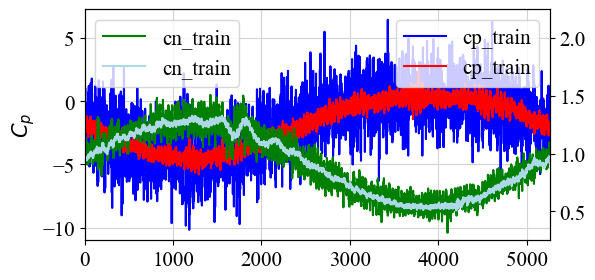

In [15]:
fig,ax=plt.subplots(figsize=(6,3))
port_show = 0
ax.plot(cp_train_indiv[:,port_show],'b', label='cp_train')
ax.plot(cp_train_phaseAve[:,port_show],'r', label='cp_train')
ax.legend(loc='upper right')
ax.grid(color='lightgray')
ax.set_xmargin(0)
ax.set_ylabel('$C_p$')

ax2 =ax.twinx()
ax2.plot(cn_train_indiv, 'g', label='cn_train')
ax2.plot(cn_train_phaseAve, 'lightblue', label='cn_train')
ax2.set_ylim([0.25,2.25])
ax2.set_xmargin(0)
ax2.legend(loc='upper left')


In [16]:
# for testing: 2nd cycle **********************************************************
start_test       = cp_train_indiv.shape[0]
cp_test_indiv    = cp_indiv_raw.iloc[start_test:start_test+len_period,:].to_numpy() # 2nd cycle
cp_test_phaseAve = cp_phaseAve.iloc[start_test:start_test+len_period,:].to_numpy() # 2nd cycle

cn_test_indiv = cn_indiv_raw.iloc[start_test:start_test+len_period,:].to_numpy()
cn_test_indiv = cn_test_indiv[:,load].reshape((-1, 1)) # reahspe to 2d

cn_test_phaseAve = cn_phaseAve.iloc[start_test:start_test+len_period,:].to_numpy()
cn_test_phaseAve = cn_test_phaseAve[:,load].reshape((-1, 1)) # reahspe to 2d

print(f'The shape of cp_train, cn_train_indiv and cn_train_phaseAve is: {cp_test_indiv.shape, cn_test_indiv.shape, cn_test_phaseAve.shape}')

The shape of cp_train, cn_train_indiv and cn_train_phaseAve is: ((5262, 15), (5262, 1), (5262, 1))


**check, plot the training and testing data**

Text(0.5, 1.0, 'case A | 1 cycle | $C_p$$_{1}$')

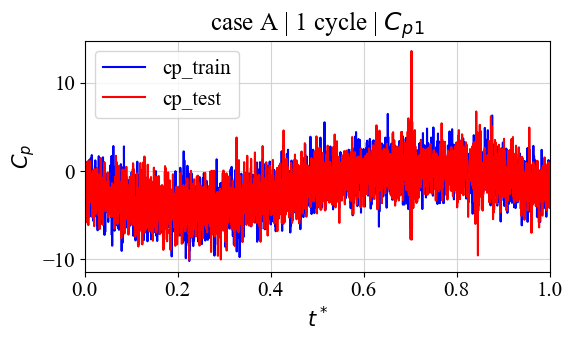

In [17]:
fig,ax=plt.subplots(figsize=(6,3))
port_show = 0
x_ticks = np.linspace(0,1,len_period)
ax.plot(x_ticks, cp_train_indiv[0:len_period,port_show],'b', label='cp_train')
ax.plot(x_ticks, cp_test_indiv[:,port_show],'r', label='cp_test')
ax.legend()
ax.grid(color='lightgray')
ax.set_xmargin(0)
ax.set_xlabel('$t^*$')
ax.set_ylabel('$C_p$')
ax.set_title('case A | 1 cycle | $C_p$' + r'${}_{{{}}}$'.format('', port_show+1))

# **Build the 1st model**  
## **regular MLP**  
    - input: cp individual raw pressure  
    - output: cl individual raw lift

In [18]:
# define a callback to predict and store the epoch predictions
# this callback will predict at every epochs you defined and store it.

class PredictMLPCallback(Callback):
    def __init__(self, cp_test_indiv, prediction_frequency=5):
        super().__init__()
        
        # Store the test data and prediction frequency
        self.P_test = cp_test_indiv
        self.prediction_frequency = prediction_frequency
        
        # Initialize an empty list to store the epoch predictions
        self.epoch_predictions = []
        
    def on_epoch_end(self, epoch, logs=None):
        # Check if the current epoch is a multiple of the prediction frequency
        if (epoch + 1) % self.prediction_frequency == 0:
            # Make predictions on the test data using the current model
            mlp_output = self.model.predict(self.P_test)
            
            # Append the predictions to the epoch predictions list
            self.epoch_predictions.append(mlp_output)
            
            # Print the predictions to the console for debugging purposes
            # print(f"Predictions at epoch {epoch + 1}: {predictions}")

In [19]:
''' build the MLP '''
def build_mlp(input_shape, output_shape, num_hidden_layers, num_neurons, activation, regularization, learn_rate, loss):
    # Define the model architecture
    mlp = Sequential()

    # Add the input layer
    mlp.add(Input(shape=input_shape))

    # Add the hidden layers
    for i in range(num_hidden_layers):
        mlp.add(Dense(num_neurons, kernel_regularizer=regularizers.l2(regularization)))
        
        # Add PReLU activation function
        if activation == 'prelu':
            mlp.add(PReLU())
        else:
            mlp.add(Activation(activation))

    # Add the output layer
    mlp.add(Dense(output_shape, activation = 'linear', kernel_regularizer=regularizers.l2(regularization)))
    
    adam = optimizers.Adam(learning_rate=learn_rate)
    
    mlp.compile(optimizer = adam, loss = loss)

    # Return the model
    return mlp

In [ ]:
# Set the hyperparameters
input_shape = (15,)
output_shape = 1
num_hidden_layers = 3 # 8 default
num_neurons =  20  # 72
activation = 'prelu'
regularization = 0 # 1e-2 is result after tunning
learn_rate =  1e-5     # 1e-5 is good
loss = 'mean_squared_error'

prediction_callback_1 = {} # the 1st model

# loop to find the best L2 regularization
# for regularization in [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]:
# after runing some test, I found 1e-2 of L2 regularization is best   

# record start time
starttime = datetime.datetime.now()

print(f'regularization is: {regularization}')

# Build the model
mlp_1 = build_mlp(input_shape, output_shape, num_hidden_layers, num_neurons, activation, regularization, learn_rate, loss)
mlp_1.summary()

# Define the custom callback
prediction_callback_1 = PredictMLPCallback(cp_test_indiv)

# Train the model with the custom callback
mlp_1.fit(cp_train_indiv, cn_train_indiv, epochs=5000, batch_size=100, verbose = 2, shuffle=False, 
          validation_split=0.0, callbacks=[prediction_callback_1])

# record end time
endtime = datetime.datetime.now()

print(f'Run time is: {(endtime - starttime).seconds}')

print('Done!')

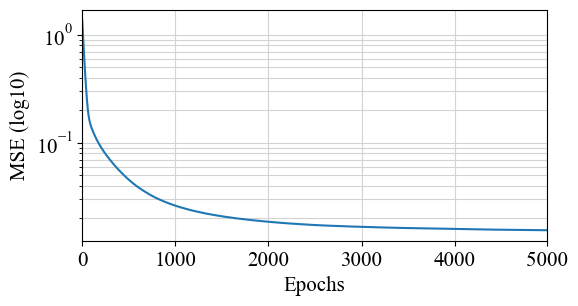

In [98]:
# Compute the MSE between the true test labels and the predicted labels
from sklearn.metrics import mean_squared_error as mse

mse_pred_per_epoch = []

for predictions in prediction_callback_1.epoch_predictions:
    mse_temp = mse(cn_test_indiv, predictions)
    mse_pred_per_epoch.append(mse_temp)

fig,ax=plt.subplots(figsize=(6,3))
# for i, regul in enumerate([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]):
for i, regul in enumerate([0]):
    ax.semilogy(mse_pred_per_epoch)
# ax.set_ylim([0.04,1])
ax.set_xticks([0, 200, 400, 600, 800, 1000-1])
ax.set_xticklabels(['0','1000','2000','3000','4000','5000'])
ax.set_xmargin(0)
ax.set_ylabel('MSE (log10)')
ax.set_xlabel('Epochs')
ax.grid(color='lightgray', which='both')
fig.savefig('./figure/mlp_1_mse.svg', dpi=350)

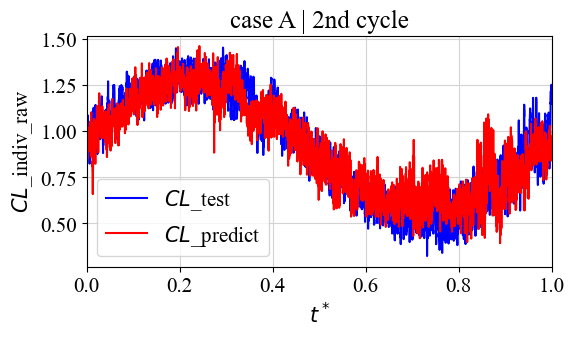

In [86]:
fig,ax=plt.subplots(figsize=(6,3))
x_ticks = np.linspace(0,1,len_period)
ax.plot(x_ticks, cn_test_indiv,'b', label='$\mathit{CL}$' + '_test')
ax.plot(x_ticks, prediction_callback_1.epoch_predictions[-1][:,0],'r', label='$\mathit{CL}$' + '_predict')
ax.grid(color='lightgray')
ax.set_xlabel('$t^*$')
ax.set_ylabel('$\mathit{CL}$' + '_indiv_raw')
ax.legend()
ax.set_xmargin(0)
ax.set_title('case A | 2nd cycle')
fig.savefig('./figure/mlp_1_cl_pred.png', dpi=350)

**check the reconstruct of the training data**

Text(0.5, 1.0, 'case A | 1 cycle')

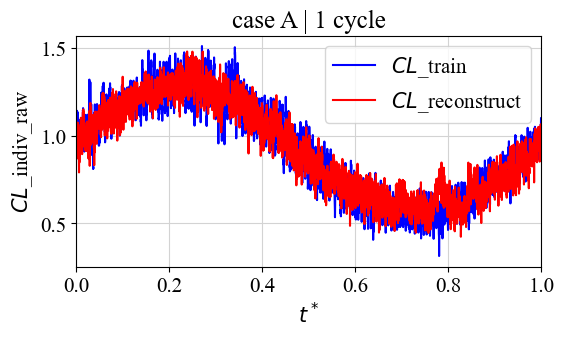

In [33]:
aaa = mlp_1.predict(cp_train_indiv)
fig,ax=plt.subplots(figsize=(6,3))
x_ticks = np.linspace(0,1,len_period*num_cycle)
ax.plot(x_ticks, cn_train_indiv,'b', label='$\mathit{CL}$' + '_train')
ax.plot(x_ticks, aaa,'r', label='$\mathit{CL}$' + '_reconstruct')
ax.grid(color='lightgray')
ax.set_xlabel('$t^*$')
ax.set_ylabel('$\mathit{CL}$' + '_indiv_raw')
ax.legend()
ax.set_xmargin(0)
ax.set_title('case A | 1 cycle')

# **Build the 2nd model**  
## **regular MLP**  
    - input:  cp individual raw pressure  
    - output: cl phase averaged lift  
**The 2nd model is the same as the 1st model**  
**with phase averaged load as the output**

In [ ]:
# Set the hyperparameters
input_shape = (15,)
output_shape = 1
num_hidden_layers = 3 # 8 default
num_neurons =  20     # 72
activation = 'prelu'
regularization = 0    # 1e-2 is result after tunning
learn_rate =  1e-5    # 1e-5 is good
loss = 'mean_squared_error'

# Train the model with the custom callback
prediction_callback_2 = {} # the 2nd model
# Define the custom callback
prediction_callback_2 = PredictMLPCallback(cp_test_indiv)

# Build the model
mlp_2 = build_mlp(input_shape, output_shape, num_hidden_layers, 
                  num_neurons, activation, regularization, 
                  learn_rate, loss)

mlp_2.fit(cp_train_indiv, cn_train_phaseAve, epochs=5000, 
          batch_size=100, verbose = 2, shuffle=False, 
          validation_split=0.0, callbacks=[prediction_callback_2])

Epoch 1/5000
53/53 - 1s - loss: 2.0991 - 516ms/epoch - 10ms/step
Epoch 2/5000
53/53 - 0s - loss: 2.0419 - 40ms/epoch - 752us/step
Epoch 3/5000
53/53 - 0s - loss: 1.9847 - 38ms/epoch - 715us/step
Epoch 4/5000
53/53 - 0s - loss: 1.9286 - 36ms/epoch - 677us/step
Epoch 5/5000
53/53 - 0s - loss: 1.8739 - 184ms/epoch - 3ms/step
Epoch 6/5000
53/53 - 0s - loss: 1.8206 - 38ms/epoch - 715us/step
Epoch 7/5000
53/53 - 0s - loss: 1.7685 - 38ms/epoch - 715us/step
Epoch 8/5000
53/53 - 0s - loss: 1.7179 - 35ms/epoch - 668us/step
Epoch 9/5000
53/53 - 0s - loss: 1.6685 - 38ms/epoch - 715us/step
Epoch 10/5000
53/53 - 0s - loss: 1.6205 - 144ms/epoch - 3ms/step
Epoch 11/5000
53/53 - 0s - loss: 1.5736 - 44ms/epoch - 827us/step
Epoch 12/5000
53/53 - 0s - loss: 1.5278 - 42ms/epoch - 790us/step
Epoch 13/5000
53/53 - 0s - loss: 1.4831 - 61ms/epoch - 1ms/step
Epoch 14/5000
53/53 - 0s - loss: 1.4395 - 38ms/epoch - 715us/step
Epoch 15/5000
53/53 - 0s - loss: 1.3970 - 153ms/epoch - 3ms/step
Epoch 16/5000
53/53 - 0s

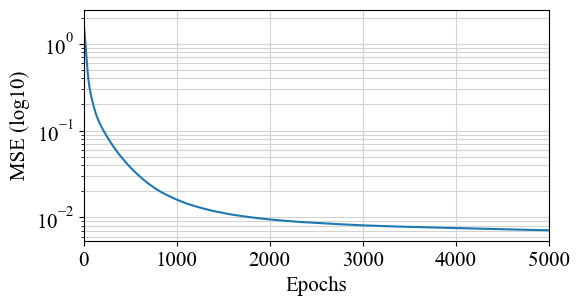

In [99]:
# Compute the MSE between the true test labels and the predicted labels
from sklearn.metrics import mean_squared_error as mse

mse_pred_per_epoch = []

for predictions in prediction_callback_2.epoch_predictions:
    mse_temp = mse(cn_test_phaseAve, predictions)
    mse_pred_per_epoch.append(mse_temp)

fig,ax=plt.subplots(figsize=(6,3))
# for i, regul in enumerate([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]):
ax.semilogy(mse_pred_per_epoch)
# ax.set_ylim([0.04,1])
ax.set_xticks([0, 200, 400, 600, 800, 1000-1])
ax.set_xticklabels(['0','1000','2000','3000','4000','5000'])
ax.set_xmargin(0)
ax.set_ylabel('MSE (log10)')
ax.set_xlabel('Epochs')
ax.grid(color='lightgray', which='both')
fig.savefig('./figure/mlp_2_mse.svg', dpi=350)

999


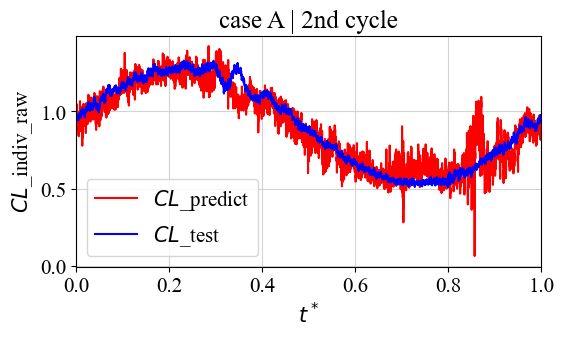

In [88]:
fig,ax=plt.subplots(figsize=(6,3))
min_val = min(mse_pred_per_epoch)
min_index = mse_pred_per_epoch.index(min_val)
print(min_index)

x_ticks = np.linspace(0,1,len_period)
ax.plot(x_ticks, prediction_callback_2.epoch_predictions[min_index][:,0],'r', label='$\mathit{CL}$' + '_predict')
ax.plot(x_ticks, cn_test_phaseAve,'b', label='$\mathit{CL}$' + '_test')
ax.grid(color='lightgray')
ax.set_xlabel('$t^*$')
ax.set_ylabel('$\mathit{CL}$' + '_indiv_raw')
ax.legend()
ax.set_xmargin(0)
ax.set_title('case A | 2nd cycle')
fig.savefig('./figure/mlp_2_cl_pred.png', dpi=350)

Text(0.5, 1.0, 'case A | 1 cycle')

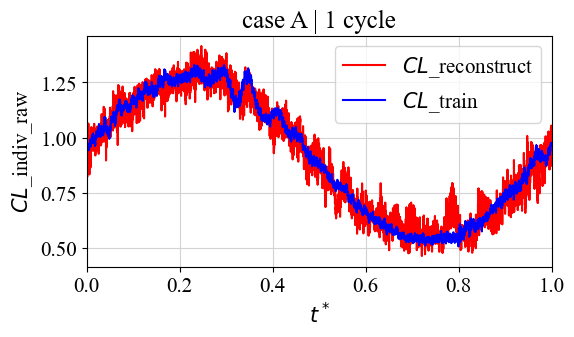

In [44]:
aaa = mlp_2.predict(cp_train_indiv)
fig,ax=plt.subplots(figsize=(6,3))
x_ticks = np.linspace(0,1,len_period*num_cycle)
ax.plot(x_ticks, aaa,'r', label='$\mathit{CL}$' + '_reconstruct')
ax.plot(x_ticks, cn_train_phaseAve,'b', label='$\mathit{CL}$' + '_train')
ax.grid(color='lightgray')
ax.set_xlabel('$t^*$')
ax.set_ylabel('$\mathit{CL}$' + '_indiv_raw')
ax.legend()
ax.set_xmargin(0)
ax.set_title('case A | 1 cycle')

# **Build the 3rd model**  
## **load embedded autoencoder with MLP**  
    - input:      cp individual raw pressure  
    - output_autoencoder: cp phase averaged pressure 
    - output_MLP: cl phase averaged lift

### **Build an autoencoder first**

In [40]:
class PredictionCallback(Callback):
    def __init__(self, x_test, prediction_frequency=5):  # cp_test_indiv for mine    
        super().__init__()
        
        self.P_test = x_test
        self.prediction_frequency = prediction_frequency

        self.epoch_predictions = []
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.prediction_frequency == 0:
            predictions = self.model.predict(self.P_test)
            self.epoch_predictions.append(predictions)

def build_autoencoder(input_shape, enc_layers, dec_layers, regularization, learn_rate, loss):
    # Define the encoder layers
    encoder_inputs = Input(shape=input_shape[0])
    encoded = Dense(enc_layers[0])(encoder_inputs)
    encoded = PReLU()(encoded)
    for i in range(1, len(enc_layers)):
        encoded = Dense(enc_layers[i])(encoded)
        encoded = PReLU()(encoded)
    encoder_outputs = encoded

    # Define the decoder layers
    decoded = Dense(dec_layers[0])(encoder_outputs) 
    decoded = PReLU()(decoded) 
    for i in range(1, len(dec_layers)):
        decoded = Dense(dec_layers[i])(decoded)
        decoded = PReLU()(decoded)
    decoder_outputs = Dense(input_shape[0])(decoded)
    decoder_outputs = decoder_outputs = Activation('linear')(decoder_outputs)
    
    # combine the encoder and the decoder
    autoencoder = Model(inputs=encoder_inputs, outputs=decoder_outputs)
    
    adam = optimizers.Adam(learning_rate=learn_rate)
    
    autoencoder.compile(optimizer = adam, loss = loss)

    return autoencoder, encoder_outputs

print('Done!')

Done!


In [ ]:
# Set the hyperparameters
input_shape = (15,)
enc_layers = [12,5]
dec_layers = [12]
regularization = 0
learn_rate = 2e-4 # 1e-5
loss = 'mean_squared_error'

# Define the custom callback
prediction_frequency = 5
prediction_callback_3_encoder = PredictionCallback(cp_test_indiv, prediction_frequency)

# Build the model
autoencoder, encoder = build_autoencoder(input_shape, enc_layers, dec_layers, regularization, learn_rate, loss)

# Print the model summary
autoencoder.summary()

# Train the model with the custom callback
autoencoder.fit(cp_train_indiv, cp_train_phaseAve, epochs=5000, batch_size=100, verbose = 2, shuffle=False, 
          validation_split=0.0, callbacks=[prediction_callback_3_encoder])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 15)]              0         
                                                                 
 dense_20 (Dense)            (None, 12)                192       
                                                                 
 p_re_lu_15 (PReLU)          (None, 12)                12        
                                                                 
 dense_21 (Dense)            (None, 5)                 65        
                                                                 
 p_re_lu_16 (PReLU)          (None, 5)                 5         
                                                                 
 dense_22 (Dense)            (None, 12)                72        
                                                                 
 p_re_lu_17 (PReLU)          (None, 12)                12    

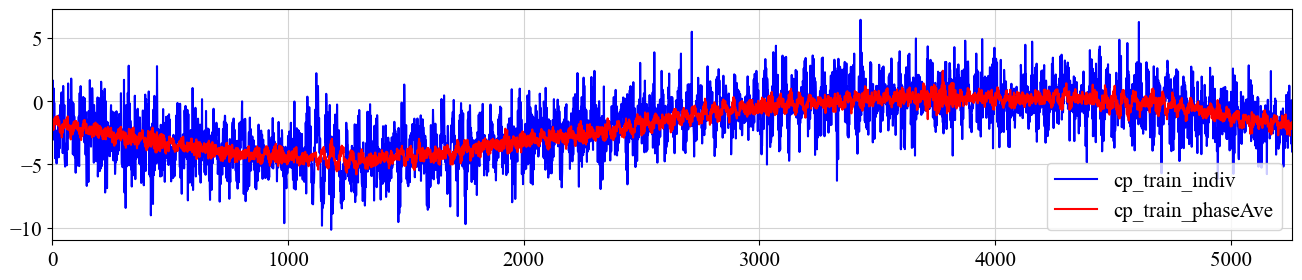

In [46]:
fig,ax=plt.subplots(figsize=(16,3))
ax.plot(cp_train_indiv[:,0],'b', label='cp_train_indiv')
ax.plot(cp_train_phaseAve[:,0],'r', label='cp_train_phaseAve')
ax.grid(color='lightgray')
ax.set_xmargin(0)
ax.legend()

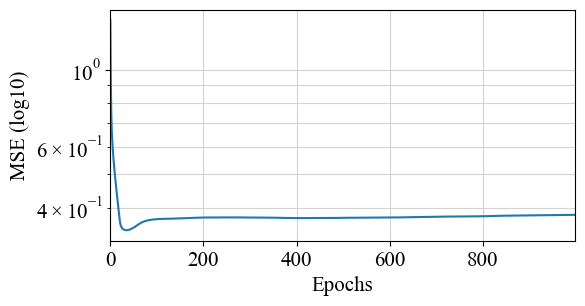

In [48]:
# Compute the MSE between the true test labels and the predicted labels
from sklearn.metrics import mean_squared_error as mse

prediction_callback_reg = prediction_callback_3_encoder
mse_pred_per_epoch = []
for predictions in prediction_callback_reg.epoch_predictions:
    mse_temp = mse(cp_test_phaseAve, predictions)
    mse_pred_per_epoch.append(mse_temp)

fig,ax=plt.subplots(figsize=(6,3))
for i, regul in enumerate([0]):
    ax.semilogy(mse_pred_per_epoch)
# ax.set_ylim([0.04,1])
# ax.set_xticks([0, 20, 40, 60, 80, 100, 150-1])
# ax.set_xticklabels(['0','40','80','120','160','200', '300'])
ax.set_xmargin(0)
ax.set_ylabel('MSE (log10)')
ax.set_xlabel('Epochs')
ax.grid(color='lightgray', which='both')

999


(-10.0, 5.0)

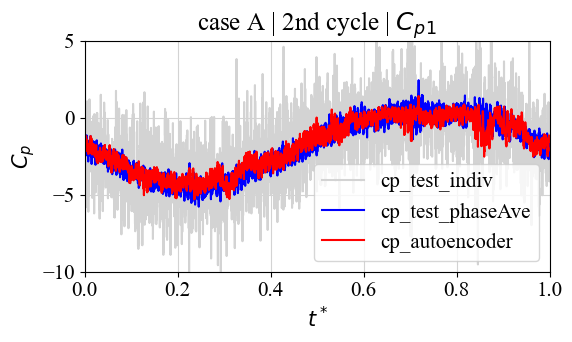

In [95]:
fig,ax=plt.subplots(figsize=(6,3))

port_show = 0
min_val = min(mse_pred_per_epoch)
min_index = mse_pred_per_epoch.index(min_val)
print(min_index)

# ax.plot(x_ticks, cp_test_indiv[:,port_show],'lightgray', label='cp_test_indiv')
ax.plot(x_ticks, cp_test_indiv[0:len_period,port_show],'lightgray', label='cp_test_indiv')
ax.plot(x_ticks, cp_test_phaseAve[:,port_show],'b', label='cp_test_phaseAve')
ax.plot(x_ticks, prediction_callback_3_encoder.epoch_predictions[min_index][:,port_show],'r', label='cp_autoencoder')
ax.grid(color='lightgray')
ax.set_xlabel('$t^*$')
ax.set_ylabel('$C_p$')
ax.legend()
ax.set_xmargin(0)
ax.set_title('case A | 2nd cycle | $C_p$' + r'${}_{{{}}}$'.format('', port_show+1))
ax.set_ylim([-10,5])

# Combine the autoencoder and MLP

## Build the autoencoder model
**do not use the model built in the above**  
**instead, define the model here, with the hyperparameters used above**

In [88]:
# Define the input shape
input_shape = (15,) # corresponding to the 15 pressure sensors

# Define the encoder part of the autoencoder
input_layer = Input(shape=input_shape) # no activation for input
encoded = Dense(12)(input_layer) # this is the hidden layer
encoded = PReLU()(encoded)       # use prelu as activation
encoded = Dense(3)(encoded)  # this is the latent layer
encoded = PReLU()(encoded)

# Define the decoder part of the autoencoder
decoded = Dense(12)(encoded)
decoded = PReLU()(decoded)
decoded = Dense(input_shape[0], activation='linear')(decoded) # use linear activation for the output layer for regression

## Build the MLP model

In [89]:
# Define the MLP
mlp = Dense(5)(encoded)  # use the latert layer as input; no activation
for i in range(30):       # 3 hidden layers
    mlp = Dense(20)(mlp) # 20 neurons for each hidden layer
    mlp = PReLU()(mlp)
mlp = Dense(1, activation='linear')(mlp) # output; the load; cd,cl

## Combine the models

In [90]:
# Combine the autoencoder and MLP into a single model
ae_mlp = Model(inputs=input_layer, outputs=[decoded, mlp])
ae_mlp.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 15)]         0           []                               
                                                                                                  
 dense_139 (Dense)              (None, 12)           192         ['input_11[0][0]']               
                                                                                                  
 p_re_lu_111 (PReLU)            (None, 12)           12          ['dense_139[0][0]']              
                                                                                                  
 dense_140 (Dense)              (None, 3)            39          ['p_re_lu_111[0][0]']            
                                                                                            

## Define the callback function
**combined loss function**  
**predict after each epopch**

In [91]:
# Define the combined loss function with a trainable weight
alpha = tf.Variable(0.00001, dtype=tf.float32)
def combined_loss(y_true, y_pred):
    # Reconstruction loss of the autoencoder
    recon_loss = keras.losses.mean_squared_error(y_true[0], y_pred[0])
    
    # Classification loss of the MLP
    class_loss = keras.losses.mean_squared_error(y_true[1], y_pred[1])
    
    # Trainable weight to balance the two losses
    global alpha
    
    # Combine the two losses with the trainable weight
    combined_loss = alpha * recon_loss + (1 - alpha) * class_loss
    
    return combined_loss

In [92]:
learn_rate = 1e-5
adam = optimizers.Adam(learning_rate=learn_rate)
        
# Compile the model with the combined loss function
ae_mlp.compile(optimizer=adam, loss=combined_loss)

# Create instance of PredictMLPCallback
predict_ae_mlp_callback = PredictMLPCallback(cp_test_indiv)

## Train the model

In [93]:
# Train the model
ae_mlp.fit(cp_train_indiv, [cp_train_phaseAve, cn_train_phaseAve], epochs=10000, batch_size=100, verbose = 2, shuffle=True,
           validation_split=0.0, callbacks=[predict_ae_mlp_callback])

Epoch 1/10000
53/53 - 3s - loss: 4.9155 - dense_142_loss: 3.9878 - dense_174_loss: 0.9277 - 3s/epoch - 58ms/step
Epoch 2/10000
53/53 - 0s - loss: 4.1674 - dense_142_loss: 3.2761 - dense_174_loss: 0.8913 - 195ms/epoch - 4ms/step
Epoch 3/10000
53/53 - 0s - loss: 4.2713 - dense_142_loss: 3.4017 - dense_174_loss: 0.8696 - 190ms/epoch - 4ms/step
Epoch 4/10000
53/53 - 0s - loss: 4.3730 - dense_142_loss: 3.3884 - dense_174_loss: 0.9846 - 197ms/epoch - 4ms/step
Epoch 5/10000
53/53 - 1s - loss: 4.7142 - dense_142_loss: 3.7544 - dense_174_loss: 0.9598 - 1s/epoch - 22ms/step
Epoch 6/10000
53/53 - 0s - loss: 4.4307 - dense_142_loss: 3.5546 - dense_174_loss: 0.8760 - 190ms/epoch - 4ms/step
Epoch 7/10000
53/53 - 0s - loss: 4.5663 - dense_142_loss: 3.5984 - dense_174_loss: 0.9679 - 193ms/epoch - 4ms/step
Epoch 8/10000
53/53 - 0s - loss: 3.9927 - dense_142_loss: 3.2064 - dense_174_loss: 0.7864 - 188ms/epoch - 4ms/step
Epoch 9/10000
53/53 - 0s - loss: 3.8035 - dense_142_loss: 3.0189 - dense_174_loss: 0

Text(0.5, 1.0, 'autoencoder')

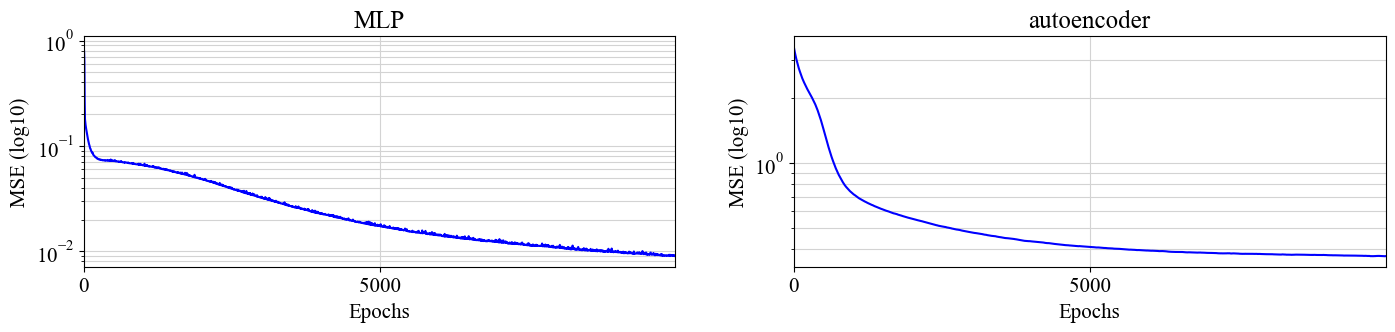

In [94]:
# Compute the MSE between the true test labels and the predicted labels
from sklearn.metrics import mean_squared_error as mse
fig,ax=plt.subplots(1,2,figsize=(6*2.8,3))

# mse for MLP part
mse_pred_per_epoch_phase = []
for i in range(len(predict_ae_mlp_callback.epoch_predictions)):
    # find the predicted load; 0 as pred Cp; 1 as pred load
    pred_load = predict_ae_mlp_callback.epoch_predictions[i][1] 
    mse_temp_phase = mse(cn_test_phaseAve, pred_load)
    mse_pred_per_epoch_phase.append(mse_temp_phase)

ax[0].semilogy(mse_pred_per_epoch_phase, 'b')
# ax.set_ylim([0.04,1])
ax[0].set_xticks([0, 1000, 2000, 3000, 4000, 5000, 6000-1])
ax[0].set_xticklabels(['0','5000','10000','15000','20000','25000','30000'])
ax[0].set_xmargin(0)
ax[0].set_ylabel('MSE (log10)')
ax[0].set_xlabel('Epochs')
ax[0].grid(color='lightgray', which='both')
ax[0].set_title('MLP')

###############################################################
# mse for autoencoder part
mse_pred_per_epoch_phase_ae = []
for i in range(len(predict_ae_mlp_callback.epoch_predictions)):
    # find the predicted load; 0 as pred Cp; 1 as pred load
    pred_cp = predict_ae_mlp_callback.epoch_predictions[i][0] 
    mse_temp_phase = mse(cp_test_phaseAve, pred_cp)
    mse_pred_per_epoch_phase_ae.append(mse_temp_phase)

ax[1].semilogy(mse_pred_per_epoch_phase_ae, 'b')
# ax.set_ylim([0.04,1])
ax[1].set_xticks([0, 1000, 2000, 3000, 4000, 5000, 6000-1])
ax[1].set_xticklabels(['0','5000','10000','15000','20000','25000','30000'])
ax[1].set_xmargin(0)
ax[1].set_ylabel('MSE (log10)')
ax[1].set_xlabel('Epochs')
ax[1].grid(color='lightgray', which='both')
ax[1].set_title('autoencoder')

# fig.savefig('./figure/ae_mlp_mse_mlp.svg', dpi=350)

1999


Text(0.5, 1.0, 'case A | 1st cycle')

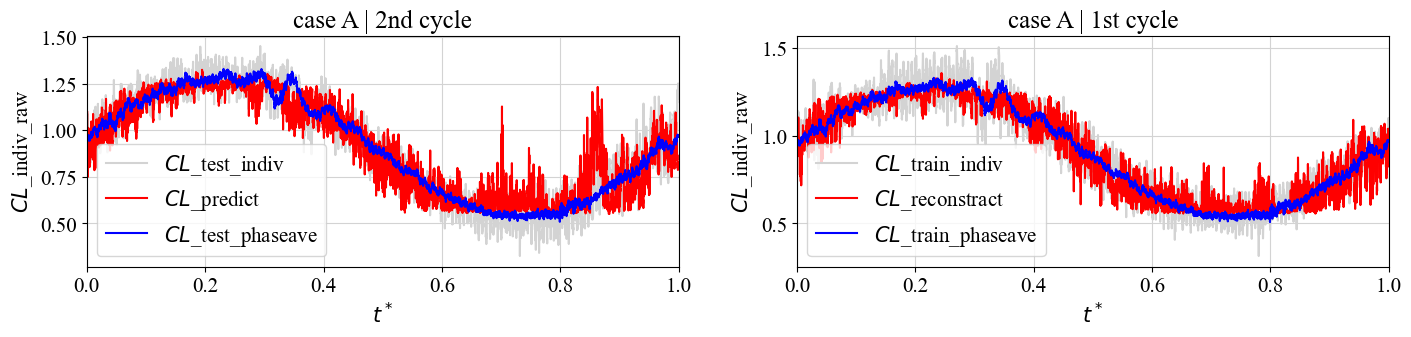

In [95]:
fig,ax=plt.subplots(1,2,figsize=(6*2.8,3))
min_val = min(mse_pred_per_epoch_phase)
min_index = mse_pred_per_epoch_phase.index(min_val)
print(min_index)

x_ticks = np.linspace(0,1,len_period)

# plot the prediction of MLP
ax[0].plot(x_ticks, cn_test_indiv, 'lightgray', label='$\mathit{CL}$' + '_test_indiv')
ax[0].plot(x_ticks, predict_ae_mlp_callback.epoch_predictions[min_index][1],'r', label='$\mathit{CL}$' + '_predict')
ax[0].plot(x_ticks, cn_test_phaseAve,'b', label='$\mathit{CL}$' + '_test_phaseave')
ax[0].grid(color='lightgray')
ax[0].set_xlabel('$t^*$')
ax[0].set_ylabel('$\mathit{CL}$' + '_indiv_raw')
ax[0].legend()
ax[0].set_xmargin(0)
ax[0].set_title('case A | 2nd cycle')

# plot the reconstruction of MLP
cn_resconstract = ae_mlp.predict(cp_train_indiv)
ax[1].plot(x_ticks, cn_train_indiv, 'lightgray', label='$\mathit{CL}$' + '_train_indiv')
ax[1].plot(x_ticks, cn_resconstract[1],'r', label='$\mathit{CL}$' + '_reconstract')
ax[1].plot(x_ticks, cn_train_phaseAve,'b', label='$\mathit{CL}$' + '_train_phaseave')
ax[1].grid(color='lightgray')
ax[1].set_xlabel('$t^*$')
ax[1].set_ylabel('$\mathit{CL}$' + '_indiv_raw')
ax[1].legend()
ax[1].set_xmargin(0)
ax[1].set_title('case A | 1st cycle')

# fig.savefig('./figure/ae_mlp_cl_pred.png', dpi=350)

1999


Text(0.5, 1.0, 'case A | 2nd cycle')

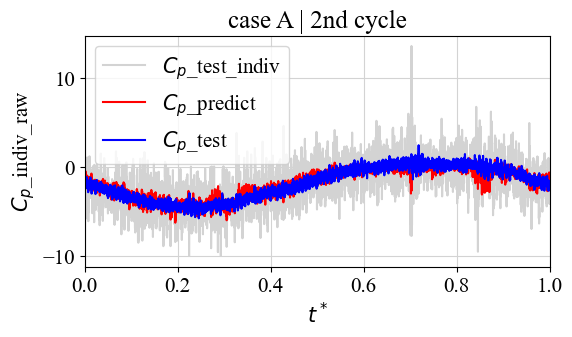

In [96]:
fig,ax=plt.subplots(figsize=(6,3))
min_val = min(mse_pred_per_epoch_phase)
min_index = mse_pred_per_epoch_phase.index(min_val)
print(min_index)

x_ticks = np.linspace(0,1,len_period)

ax.plot(x_ticks, cp_test_indiv[:,0], 'lightgray', label='$\mathit{C_p}$' + '_test_indiv')
ax.plot(x_ticks, predict_ae_mlp_callback.epoch_predictions[min_index][0][:,0],'r', label='$\mathit{C_p}$' + '_predict')
ax.plot(x_ticks, cp_test_phaseAve[:,0],'b', label='$\mathit{C_p}$' + '_test')
ax.grid(color='lightgray')
ax.set_xlabel('$t^*$')
ax.set_ylabel('$\mathit{C_p}$' + '_indiv_raw')
ax.legend()
ax.set_xmargin(0)
ax.set_title('case A | 2nd cycle')
# fig.savefig('./figure/ae_mlp_cp1_pred.png', dpi=350)